# How Pollutants and Air Pollution Affect the Climate in NYC # 


## Libraries Import ##

In [418]:
import pandas as pd
import seaborn as sns
import numpy as np

import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_log_error

import warnings
warnings.filterwarnings('ignore')

In [4]:
def PRINT(msg):
    print('--------------------------------------------------------------------------------------------------')
    print(msg)
    print('--------------------------------------------------------------------------------------------------')

## Data Preprocessing ##

### Preprocess NYC Pollutants Dataset ###

In [299]:
ny_o3_2016_df = pd.read_csv(os.path.join('datasets', 'pollution_datasets', 'ny_ozone_2016.csv'))
ny_o3_2016_df.head()

,Date,Source,Site ID,POC,Ozone,Units,AQI,Local Site Name,Daily Obs Count,Percent Complete,...,AQS Parameter Description,Method Code,CBSA Code,CBSA Name,State FIPS Code,State,County FIPS Code,County,Site Latitude,Site Longitude
0,01/01/2016,AQS,360010012,1,0.031,ppm,29,LOUDONVILLE,17,100,...,Ozone,87,10580.0,"Albany-Schenectady-Troy, NY",36,New York,1,Albany,42.68075,-73.75733
1,01/02/2016,AQS,360010012,1,0.027,ppm,25,LOUDONVILLE,17,100,...,Ozone,87,10580.0,"Albany-Schenectady-Troy, NY",36,New York,1,Albany,42.68075,-73.75733
2,01/03/2016,AQS,360010012,1,0.026,ppm,24,LOUDONVILLE,17,100,...,Ozone,87,10580.0,"Albany-Schenectady-Troy, NY",36,New York,1,Albany,42.68075,-73.75733
3,01/04/2016,AQS,360010012,1,0.026,ppm,24,LOUDONVILLE,17,100,...,Ozone,87,10580.0,"Albany-Schenectady-Troy, NY",36,New York,1,Albany,42.68075,-73.75733
4,01/05/2016,AQS,360010012,1,0.025,ppm,23,LOUDONVILLE,17,100,...,Ozone,87,10580.0,"Albany-Schenectady-Troy, NY",36,New York,1,Albany,42.68075,-73.75733


In [351]:
ny_o3_2016_df.columns

Index(['Date', 'Source', 'Site ID', 'POC', 'Ozone', 'Units', 'AQI',
       'Local Site Name', 'Daily Obs Count', 'Percent Complete',
       'AQS Parameter Code', 'AQS Parameter Description', 'Method Code',
       'CBSA Code', 'CBSA Name', 'State FIPS Code', 'State',
       'County FIPS Code', 'County', 'Site Latitude', 'Site Longitude'],
      dtype='object')

In [21]:
o3_2016_df = ny_o3_2016_df[['Date', 'Daily Max 8-hour Ozone Concentration', 'Units', 'Daily AQI Value', 'County']].copy()
o3_2016_df.rename(columns={'Daily Max 8-hour Ozone Concentration':'o3', 'Daily AQI Value': 'AQI'}, inplace=True)
o3_2016_df

,Date,o3,Units,AQI,County
0,01/01/2016,0.031,ppm,29,Albany
1,01/02/2016,0.027,ppm,25,Albany
2,01/03/2016,0.026,ppm,24,Albany
3,01/04/2016,0.026,ppm,24,Albany
4,01/05/2016,0.025,ppm,23,Albany
...,...,...,...,...,...
10326,12/26/2016,0.029,ppm,27,Westchester
10327,12/27/2016,0.029,ppm,27,Westchester
10328,12/28/2016,0.027,ppm,25,Westchester
10329,12/29/2016,0.024,ppm,22,Westchester


We need to preprocess the data first. As we can see, we have data for all New York counties (e.g., Albany, Bronx, etc.). Therefore, we will average the O₃ and AQI values for each day across all counties. This way, for every day, we will have the average ozone and AQI values representing the overall average for the state of New York

In [38]:
o3_2016_df['Date'] = pd.to_datetime(o3_2016_df['Date'])
o3_daily_avg_df = o3_2016_df.groupby('Date')[['o3', 'AQI']].mean().reset_index() # group by date and compute average of 'o3' and 'AQ
o3_daily_avg_df.rename(columns={'o3': 'avg_o3', 'AQI': 'avg_AQI'}, inplace=True)

In [39]:
o3_daily_avg_df.head()

,Date,avg_o3,avg_AQI
0,2016-01-01,0.031750,29.333333
1,2016-01-02,0.028292,26.208333
2,2016-01-03,0.028957,26.913043
3,2016-01-04,0.028810,26.761905
4,2016-01-05,0.028545,26.454545


Next, we will preprocess each dataset for the pollutants O₃, NO₂, CO, PM₂.₅, and PM₁₀. For each pollutant, we will generate a dictionary where the keys are the years (2016, 2018, 2020, and 2021), and the values are the corresponding DataFrames.

In [560]:
def preprocess_pollutant(pollutant) -> pd.DataFrame():
    pollutant_dict = {}
    years = ['2016', '2018', '2020', '2021']
    for year in years: 
        # load current dataset, select relevant columns & rename them
        curr_df = pd.read_csv(os.path.join('datasets', 'pollution_datasets', f'ny_{pollutant.lower()}_{year}.csv'))
        curr_df = curr_df[['Date',f'{pollutant}', 'AQI', 'County','Site Latitude', 'Site Longitude']].copy()

        # group by date and compute average of pollutant and other numeric values
        curr_df['Date'] = pd.to_datetime(curr_df['Date'])
        curr_df = curr_df.groupby('Date')[[f'{pollutant}', 'AQI','Site Latitude', 'Site Longitude']].mean().reset_index()
        curr_df.rename(columns={f'{pollutant}': f'avg_{pollutant}'}, inplace=True)
        
        pollutant_dict[year] = curr_df
    return pollutant_dict

In [600]:
o3_dict = preprocess_pollutant('Ozone')
no2_dict = preprocess_pollutant('NO2')
pm2d5_dict = preprocess_pollutant('PM2.5')
co_dict = preprocess_pollutant('CO')

In [562]:
o3_dict['2021']

,Date,avg_Ozone,AQI,Site Latitude,Site Longitude
0,2021-01-01,0.029370,27.259259,42.359143,-75.149650
1,2021-01-02,0.029333,27.222222,42.359143,-75.149650
2,2021-01-03,0.027148,25.148148,42.359143,-75.149650
3,2021-01-04,0.023852,22.111111,42.359143,-75.149650
4,2021-01-05,0.027000,24.962963,42.359143,-75.149650
...,...,...,...,...,...
359,2021-12-26,0.029000,26.884615,42.303041,-74.987181
360,2021-12-27,0.024652,22.739130,42.358073,-75.040164
361,2021-12-28,0.021462,19.769231,42.303041,-74.987181
362,2021-12-29,0.017000,15.692308,42.303041,-74.987181


The next step is to `concatenate` the DataFrames for each pollutant to create a single DataFrame per pollutant, containing pollution level data for the years 2016, 2018, 2020, and 2021. Then, we will `merge` all these DataFrames to generate a final DataFrame where each row represents a single day, with information about all pollutants combined.

In [601]:
o3_df = pd.concat([o3_dict['2016'], o3_dict['2018'], o3_dict['2020'], o3_dict['2021']], axis=0).reset_index(drop=True)
no2_df = pd.concat([no2_dict['2016'], no2_dict['2018'], no2_dict['2020'], no2_dict['2021']], axis=0).reset_index(drop=True)
pm2d5_df = pd.concat([pm2d5_dict['2016'], pm2d5_dict['2018'], pm2d5_dict['2020'], pm2d5_dict['2021']], axis=0).reset_index(drop=True)
co_df = pd.concat([co_dict['2016'], co_dict['2018'], co_dict['2020'], co_dict['2021']], axis=0).reset_index(drop=True)

In [564]:
o3_df

,Date,avg_Ozone,AQI,Site Latitude,Site Longitude
0,2016-01-01,0.031750,29.333333,42.286214,-74.860975
1,2016-01-02,0.028292,26.208333,42.286214,-74.860975
2,2016-01-03,0.028957,26.913043,42.235633,-74.875963
3,2016-01-04,0.028810,26.761905,42.229930,-74.553264
4,2016-01-05,0.028545,26.454545,42.242189,-74.769880
...,...,...,...,...,...
1453,2021-12-26,0.029000,26.884615,42.303041,-74.987181
1454,2021-12-27,0.024652,22.739130,42.358073,-75.040164
1455,2021-12-28,0.021462,19.769231,42.303041,-74.987181
1456,2021-12-29,0.017000,15.692308,42.303041,-74.987181


In [602]:
nyc_pollutant_df = o3_df.merge(no2_df, how='inner', on='Date', suffixes=('_o3', '_no2')).merge(pm2d5_df, how='inner', on='Date', suffixes=('_no2', '_pm2.5')).merge(co_df, how='inner', on='Date', suffixes=('_pm2.5', '_co'))

In [604]:
PRINT(f'Number of null values in nyc_pollutant_df -> {nyc_pollutant_df.isna().sum().sum()}')

--------------------------------------------------------------------------------------------------
Number of null values in nyc_pollutant_df -> 0
--------------------------------------------------------------------------------------------------


In [603]:
nyc_pollutant_df

,Date,avg_Ozone,AQI_o3,Site Latitude_o3,Site Longitude_o3,avg_NO2,AQI_no2,Site Latitude_no2,Site Longitude_no2,avg_PM2.5,AQI_pm2.5,Site Latitude_pm2.5,Site Longitude_pm2.5,avg_CO,AQI_co,Site Latitude_co,Site Longitude_co
0,2016-01-01,0.031750,29.333333,42.286214,-74.860975,10.300000,9.285714,42.334806,-75.918465,6.424490,34.836735,41.672206,-75.072720,0.233333,2.444444,42.142797,-76.143976
1,2016-01-02,0.028292,26.208333,42.286214,-74.860975,13.457143,12.285714,42.334806,-75.918465,9.951724,50.172414,41.537766,-75.054478,0.288889,3.000000,42.142797,-76.143976
2,2016-01-03,0.028957,26.913043,42.235633,-74.875963,17.785714,16.428571,42.334806,-75.918465,10.472414,50.655172,41.537766,-75.054478,0.288889,3.111111,42.142797,-76.143976
3,2016-01-04,0.028810,26.761905,42.229930,-74.553264,14.571429,13.428571,42.334806,-75.918465,6.285106,33.765957,41.634695,-75.121472,0.288889,3.111111,42.142797,-76.143976
4,2016-01-05,0.028545,26.454545,42.242189,-74.769880,34.428571,32.428571,42.334806,-75.918465,10.517241,49.724138,41.618387,-75.125652,0.455556,5.222222,42.142797,-76.143976
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1453,2021-12-26,0.029000,26.884615,42.303041,-74.987181,10.975000,10.000000,41.632918,-75.461374,6.446875,35.531250,41.757108,-75.060843,0.460000,5.100000,41.830471,-75.849519
1454,2021-12-27,0.024652,22.739130,42.358073,-75.040164,22.075000,20.500000,41.632918,-75.461374,4.963636,27.545455,41.870328,-75.272893,0.270000,2.900000,41.830471,-75.849519
1455,2021-12-28,0.021462,19.769231,42.303041,-74.987181,23.475000,21.875000,41.632918,-75.461374,9.670968,49.806452,41.787345,-75.096733,0.330000,3.700000,41.830471,-75.849519
1456,2021-12-29,0.017000,15.692308,42.303041,-74.987181,20.042857,18.714286,41.760583,-75.696185,11.284375,53.531250,41.757108,-75.060843,0.340000,3.800000,41.830471,-75.849519


## Preprocess NYC Weather Dataset ##

In [634]:
ny_weather_df = pd.read_csv(os.path.join('datasets', 'NYC_Weather_2016_2022.csv'))
ny_weather_df

,time,temperature_2m (°C),precipitation (mm),rain (mm),cloudcover (%),cloudcover_low (%),cloudcover_mid (%),cloudcover_high (%),windspeed_10m (km/h),winddirection_10m (°)
0,2016-01-01T00:00,7.6,0.0,0.0,69.0,53.0,0.0,72.0,10.0,296.0
1,2016-01-01T01:00,7.5,0.0,0.0,20.0,4.0,0.0,56.0,9.8,287.0
2,2016-01-01T02:00,7.1,0.0,0.0,32.0,3.0,0.0,99.0,9.7,285.0
3,2016-01-01T03:00,6.6,0.0,0.0,35.0,5.0,0.0,100.0,9.2,281.0
4,2016-01-01T04:00,6.3,0.0,0.0,34.0,4.0,0.0,100.0,9.1,279.0
...,...,...,...,...,...,...,...,...,...,...
59755,2022-10-25T19:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
59756,2022-10-25T20:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
59757,2022-10-25T21:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
59758,2022-10-25T22:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


*NYC dataframe columns*:

- temperature_2m (oC) - Air temperature at 2 meters above ground

- precipitation (mm) - Total precipitation (rain, showers, snow) sum of the preceding hour. Data is stored with a 0.1 mm precision.

- rain (mm) - Only liquid precipitation of the preceding hour including local showers and rain

- cloudcover (%) - Total cloud cover as an area fraction

- cloudcover_low (%) - Low level clouds and fog up to 2 km altitude

- cloudcover_mid (%) - Mid level clouds from 2 to 6 km altitude

- cloudcover_high (%) - High level clouds from 6 km altitude

- windspeed_10m (km/h) - Wind speed at 10 meters above ground.

- winddirection_10m (°) - Wind direction at 10 meters above ground

#### Data Cleaning ####

In [635]:
ny_weather_df.isnull().sum()

time                       0
temperature_2m (°C)      168
precipitation (mm)       168
rain (mm)                168
cloudcover (%)           168
cloudcover_low (%)       168
cloudcover_mid (%)       168
cloudcover_high (%)      168
windspeed_10m (km/h)     168
winddirection_10m (°)    173
dtype: int64

As we can see, there are `NaN` values in our DataFrame. Therefore, we will remove them to ensure that the data is valid for training machine learning models. We chose to remove these values because the number of nulls is small relative to the overall dataset size, so we assume this will not negatively impact the model's performance or its ability to generalize.

In [636]:
ny_weather_df = ny_weather_df.dropna()
PRINT(f'Number of null values -> {ny_weather_df.isnull().sum().sum()}')

--------------------------------------------------------------------------------------------------
Number of null values -> 0
--------------------------------------------------------------------------------------------------


#### Merge All Pollutants Datasets ####

In [637]:
# seperate the time from the date column in order to group by the date and calculate average values for each day
ny_weather_df['time'] = pd.to_datetime(ny_weather_df['time'])
ny_weather_df['day'] = ny_weather_df['time'].dt.date

# group by 'day' and take the mean of all numeric columns
daily_avg_df = ny_weather_df.groupby('day').mean().reset_index()
daily_avg_df.drop(columns=['time'], inplace=True)
daily_avg_df.rename(columns={'day': 'Date'}, inplace=True)
daily_avg_df['Date'] = pd.to_datetime(daily_avg_df['Date'])

In [638]:
daily_avg_df

,Date,temperature_2m (°C),precipitation (mm),rain (mm),cloudcover (%),cloudcover_low (%),cloudcover_mid (%),cloudcover_high (%),windspeed_10m (km/h),winddirection_10m (°)
0,2016-01-01,5.408333,0.0000,0.0000,57.291667,34.500000,9.708333,77.750000,12.475000,273.333333
1,2016-01-02,2.387500,0.0000,0.0000,10.250000,9.916667,1.416667,1.500000,13.375000,266.416667
2,2016-01-03,3.012500,0.0000,0.0000,10.291667,11.291667,0.083333,0.000000,12.750000,244.375000
3,2016-01-04,0.100000,0.0000,0.0000,14.750000,11.833333,6.750000,0.000000,16.854167,313.541667
4,2016-01-05,-6.775000,0.0000,0.0000,0.666667,0.750000,0.000000,0.000000,17.645833,304.250000
...,...,...,...,...,...,...,...,...,...,...
2478,2022-10-14,15.458333,0.5250,0.5250,49.333333,32.500000,54.458333,25.708333,11.466667,160.833333
2479,2022-10-15,14.200000,0.0000,0.0000,9.875000,10.125000,0.083333,2.250000,8.337500,201.125000
2480,2022-10-17,14.687500,0.0375,0.0375,66.083333,24.958333,39.041667,81.583333,8.212500,249.208333
2481,2022-10-18,11.941667,0.0625,0.0625,39.750000,3.583333,51.083333,19.000000,10.683333,175.416667


In [639]:
merged_df = daily_avg_df.merge(nyc_pollutant_df, how='inner', on='Date')

In [640]:
merged_df

,Date,temperature_2m (°C),precipitation (mm),rain (mm),cloudcover (%),cloudcover_low (%),cloudcover_mid (%),cloudcover_high (%),windspeed_10m (km/h),winddirection_10m (°),...,Site Latitude_no2,Site Longitude_no2,avg_PM2.5,AQI_pm2.5,Site Latitude_pm2.5,Site Longitude_pm2.5,avg_CO,AQI_co,Site Latitude_co,Site Longitude_co
0,2016-01-01,5.408333,0.000000,0.000000,57.291667,34.500000,9.708333,77.750000,12.475000,273.333333,...,42.334806,-75.918465,6.424490,34.836735,41.672206,-75.072720,0.233333,2.444444,42.142797,-76.143976
1,2016-01-02,2.387500,0.000000,0.000000,10.250000,9.916667,1.416667,1.500000,13.375000,266.416667,...,42.334806,-75.918465,9.951724,50.172414,41.537766,-75.054478,0.288889,3.000000,42.142797,-76.143976
2,2016-01-03,3.012500,0.000000,0.000000,10.291667,11.291667,0.083333,0.000000,12.750000,244.375000,...,42.334806,-75.918465,10.472414,50.655172,41.537766,-75.054478,0.288889,3.111111,42.142797,-76.143976
3,2016-01-04,0.100000,0.000000,0.000000,14.750000,11.833333,6.750000,0.000000,16.854167,313.541667,...,42.334806,-75.918465,6.285106,33.765957,41.634695,-75.121472,0.288889,3.111111,42.142797,-76.143976
4,2016-01-05,-6.775000,0.000000,0.000000,0.666667,0.750000,0.000000,0.000000,17.645833,304.250000,...,42.334806,-75.918465,10.517241,49.724138,41.618387,-75.125652,0.455556,5.222222,42.142797,-76.143976
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1453,2021-12-26,7.966667,0.004167,0.004167,40.958333,32.208333,17.958333,6.833333,14.029167,310.791667,...,41.632918,-75.461374,6.446875,35.531250,41.757108,-75.060843,0.460000,5.100000,41.830471,-75.849519
1454,2021-12-27,2.783333,0.000000,0.000000,45.791667,12.666667,45.541667,40.125000,7.545833,218.875000,...,41.632918,-75.461374,4.963636,27.545455,41.870328,-75.272893,0.270000,2.900000,41.830471,-75.849519
1455,2021-12-28,4.304167,0.091667,0.091667,76.166667,46.791667,64.375000,54.250000,7.887500,220.958333,...,41.632918,-75.461374,9.670968,49.806452,41.787345,-75.096733,0.330000,3.700000,41.830471,-75.849519
1456,2021-12-29,5.854167,0.212500,0.212500,94.333333,72.291667,51.291667,59.000000,6.279167,64.375000,...,41.760583,-75.696185,11.284375,53.531250,41.757108,-75.060843,0.340000,3.800000,41.830471,-75.849519


In [641]:
PRINT(f'Columns -> {list(merged_df.columns)}')

--------------------------------------------------------------------------------------------------
Columns -> ['Date', 'temperature_2m (°C)', 'precipitation (mm)', 'rain (mm)', 'cloudcover (%)', 'cloudcover_low (%)', 'cloudcover_mid (%)', 'cloudcover_high (%)', 'windspeed_10m (km/h)', 'winddirection_10m (°)', 'avg_Ozone', 'AQI_o3', 'Site Latitude_o3', 'Site Longitude_o3', 'avg_NO2', 'AQI_no2', 'Site Latitude_no2', 'Site Longitude_no2', 'avg_PM2.5', 'AQI_pm2.5', 'Site Latitude_pm2.5', 'Site Longitude_pm2.5', 'avg_CO', 'AQI_co', 'Site Latitude_co', 'Site Longitude_co']
--------------------------------------------------------------------------------------------------


### Normaliza the Dataset ###

To ensure that no column dominates others due to its significantly larger value range—and at the same time preserve the relative distribution of values within each column—we will normalize the dataset using the Min-Max normalization algorithm. This will scale each column to a range between 0 and 1.

In [642]:
# Only include the columns you want to normalize (excluding temp & rain)
cols_to_normalize = ['cloudcover (%)', 'cloudcover_low (%)',
                     'cloudcover_mid (%)', 'cloudcover_high (%)', 'windspeed_10m (km/h)', 'winddirection_10m (°)',
                     'avg_Ozone', 'AQI_o3', 'Site Latitude_o3', 'Site Longitude_o3', 'avg_NO2', 'AQI_no2', 'Site Latitude_no2',
                     'Site Longitude_no2', 'avg_PM2.5', 'AQI_pm2.5', 'Site Latitude_pm2.5', 'Site Longitude_pm2.5',
                     'avg_CO', 'AQI_co', 'Site Latitude_co', 'Site Longitude_co'
                    ]

scaler = MinMaxScaler()
merged_df[cols_to_normalize] = scaler.fit_transform(merged_df[cols_to_normalize])

In [643]:
merged_df.head()

,Date,temperature_2m (°C),precipitation (mm),rain (mm),cloudcover (%),cloudcover_low (%),cloudcover_mid (%),cloudcover_high (%),windspeed_10m (km/h),winddirection_10m (°),...,Site Latitude_no2,Site Longitude_no2,avg_PM2.5,AQI_pm2.5,Site Latitude_pm2.5,Site Longitude_pm2.5,avg_CO,AQI_co,Site Latitude_co,Site Longitude_co
0,2016-01-01,5.408333,0.0,0.0,0.572917,0.345000,0.097327,0.7775,0.339782,0.786218,...,0.846284,0.322009,0.122210,0.238784,0.409413,0.462973,0.121951,0.117021,0.777091,0.4324
1,2016-01-02,2.387500,0.0,0.0,0.102500,0.099167,0.014202,0.0150,0.372430,0.765681,...,0.846284,0.322009,0.198131,0.363844,0.234408,0.478060,0.182927,0.170213,0.777091,0.4324
2,2016-01-03,3.012500,0.0,0.0,0.102917,0.112917,0.000835,0.0000,0.349758,0.700235,...,0.846284,0.322009,0.209339,0.367781,0.234408,0.478060,0.182927,0.180851,0.777091,0.4324
3,2016-01-04,0.100000,0.0,0.0,0.147500,0.118333,0.067669,0.0000,0.498640,0.905604,...,0.846284,0.322009,0.119210,0.230052,0.360584,0.422649,0.182927,0.180851,0.777091,0.4324
4,2016-01-05,-6.775000,0.0,0.0,0.006667,0.007500,0.000000,0.0000,0.527358,0.878016,...,0.846284,0.322009,0.210304,0.360189,0.339355,0.419191,0.365854,0.382979,0.777091,0.4324


## Data Visualization & Conclusions ##

### Correlation Heatmap ###

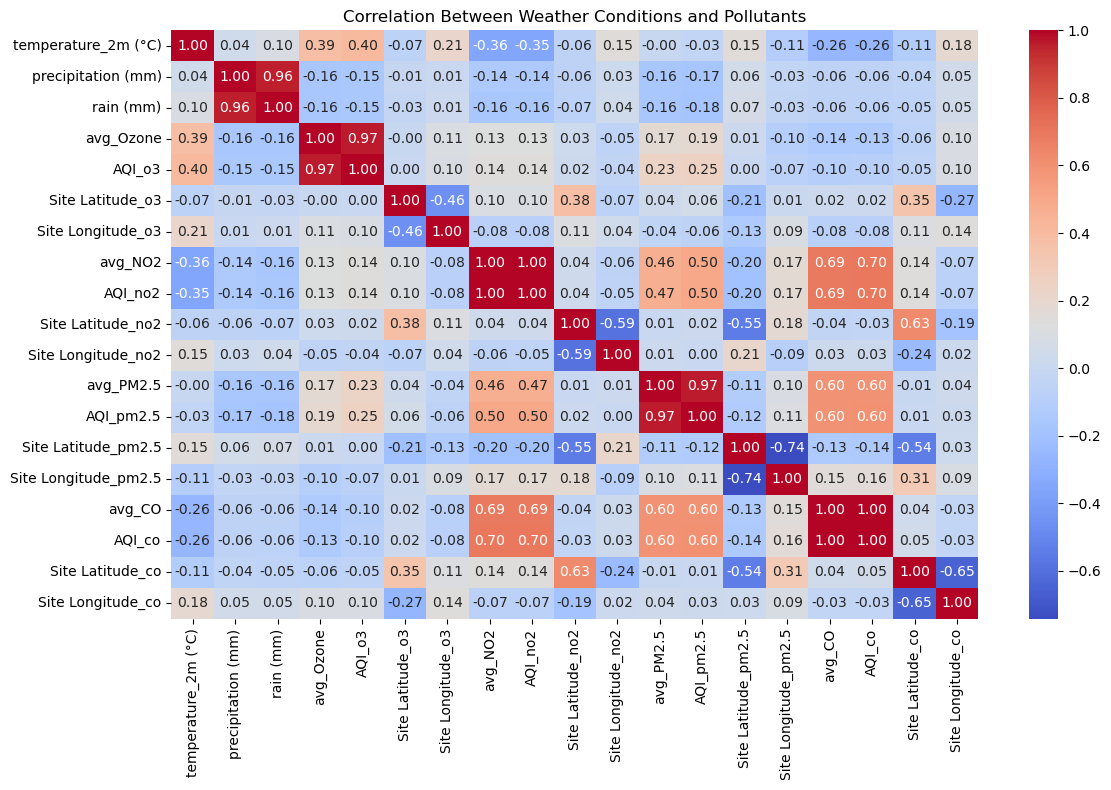

In [644]:
corr_df = merged_df[['temperature_2m (°C)', 'precipitation (mm)', 'rain (mm)',
                     'avg_Ozone', 'AQI_o3', 'Site Latitude_o3', 'Site Longitude_o3', 'avg_NO2', 'AQI_no2', 'Site Latitude_no2',
                     'Site Longitude_no2', 'avg_PM2.5', 'AQI_pm2.5', 'Site Latitude_pm2.5', 'Site Longitude_pm2.5',
                     'avg_CO', 'AQI_co', 'Site Latitude_co', 'Site Longitude_co'
                    ]]


plt.figure(figsize=(12, 8))
sns.heatmap(corr_df.corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Between Weather Conditions and Pollutants')
plt.tight_layout()
plt.show()


#### Graph Conclusions ####

From the heatmap above, we can see a clear correlation between ozone and temperature, suggesting that ozone levels may influence temperature values. Moreover, there is noticeable correlation among the pollutants—for example, a correlation of nearly 0.7 between CO and NO₂. We also observe expected correlations among various weather factors, which aligns with our assumptions. Moreover, there is no correlation between any pollutant and rain/ precipitation - we will not include those label in our future ml model.

Next, we'll investigate the correlation between ozone and temperature alone in separate graph

### Correlation Between Ozone and Temperature ###

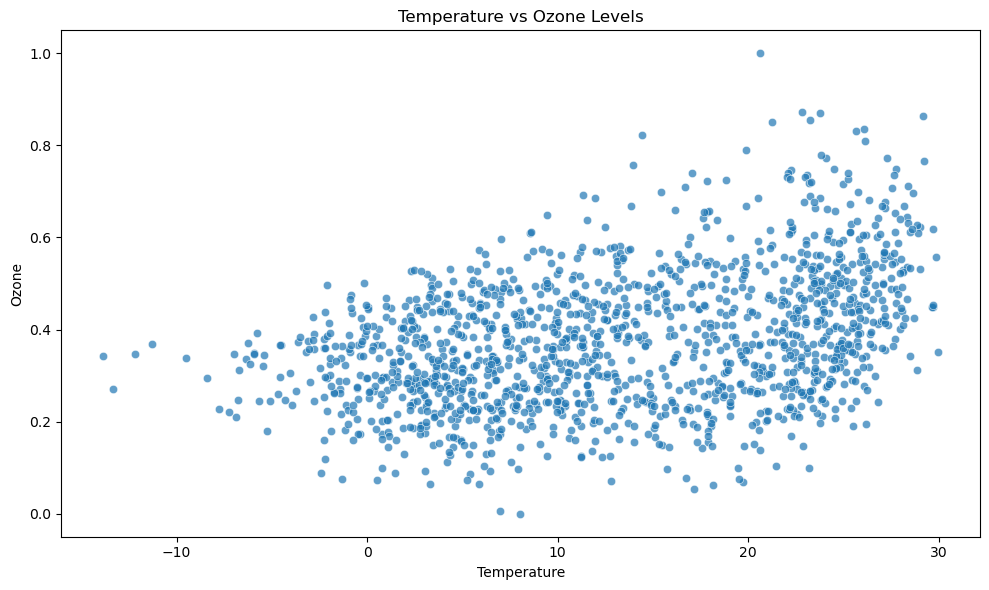

In [645]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='temperature_2m (°C)', y='avg_Ozone', data=merged_df, alpha=0.7)
plt.title('Temperature vs Ozone Levels')
plt.xlabel('Temperature')
plt.ylabel('Ozone')
plt.tight_layout()
plt.show()


#### Graph Conclusions ####

In the graph above, we can observe a slight correlation between ozone and temperature. Specifically, when the temperature is low, ozone levels are also low, and as the temperature increases, ozone levels tend to rise as well.

### Comparison of Pollutant Levels in 2016, 2018, 2020, and 2021 ###

In [646]:
pollutantse = ['avg_Ozone', 'avg_NO2', 'avg_PM2.5', 'avg_CO']

df = merged_df.copy()
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df['Year'] = df.index.year

# group by year and take mean
yearly_avg = df.groupby('Year')[pollutants].mean().reset_index()
yearly_avg

,Year,avg_Ozone,avg_NO2,avg_PM2.5,avg_CO
0,2016,0.383936,0.309350,0.125269,0.191494
1,2018,0.372428,0.331748,0.126495,0.217706
2,2020,0.368549,0.279456,0.112938,0.189580
3,2021,0.378573,0.271996,0.132264,0.196319


#### Boxplot Graph: Yearly Distribution of Pollutant Levels in NYC ####

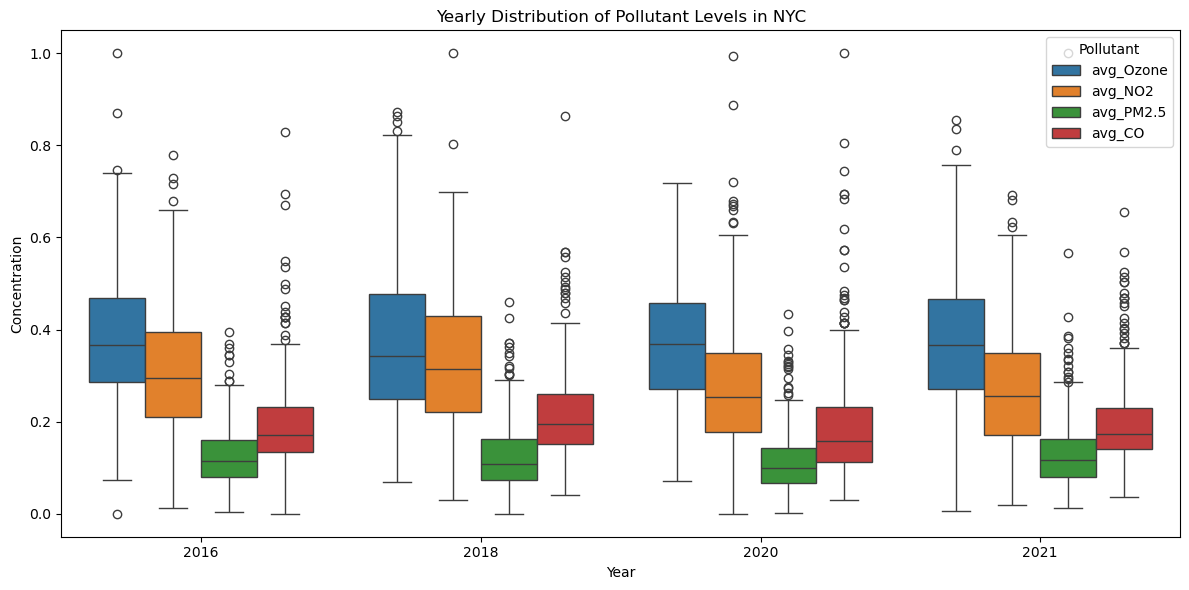

In [647]:
df = merged_df.copy()
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df['Year'] = df.index.year

pollutants = ['avg_Ozone', 'avg_NO2', 'avg_PM2.5', 'avg_CO']
df_long = df.melt(id_vars='Year', value_vars=pollutants, 
                  var_name='Pollutant', value_name='Concentration')

plt.figure(figsize=(12, 6))
sns.boxplot(data=df_long, x='Year', y='Concentration', hue='Pollutant')
plt.title('Yearly Distribution of Pollutant Levels in NYC')
plt.xlabel('Year')
plt.ylabel('Concentration')
plt.legend(title='Pollutant')
plt.tight_layout()
plt.show()

##### Graph Conclusions #####
As we can see from the boxplot above, the Q2 (median) and Q3 values of every pollutant in 2020 were lower than in the other years (2016, 2018, and 2021). This provides further visual evidence that during the peak of the COVID-19 pandemic, pollutant levels were lower compared to other years, suggesting that the lockdown had a significant impact on air pollution levels due to various factors such as reduced traffic, industrial slowdown, and decreased human activity.

#### Barplot Graph: Yearly Averages of Pollutants ####

In [648]:
melted_avg = yearly_avg.melt(id_vars='Year', var_name='Variable', value_name='Average')

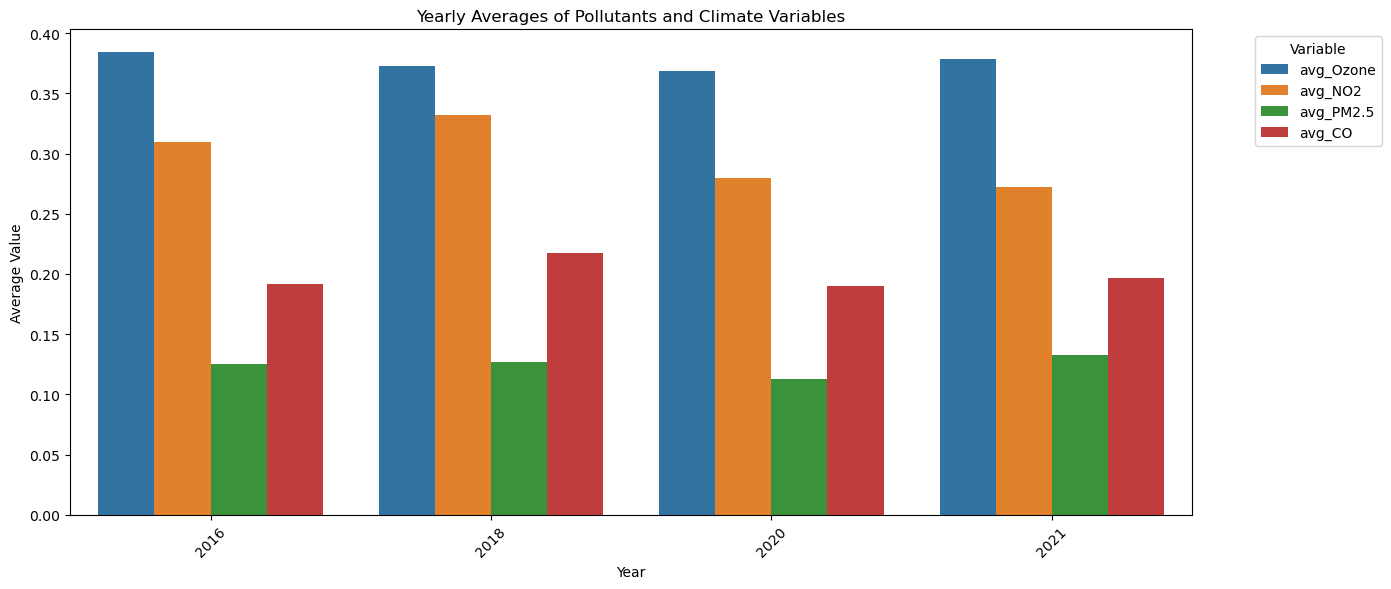

In [649]:
plt.figure(figsize=(14, 6))
sns.barplot(data=melted_avg, x='Year', y='Average', hue='Variable')
plt.title('Yearly Averages of Pollutants and Climate Variables')
plt.ylabel('Average Value')
plt.xlabel('Year')
plt.xticks(rotation=45)
plt.legend(title='Variable', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


##### Graph Conclusions #####

Just as we observed in the boxplot above, the barplot here also clearly shows that the average value of each individual pollutant was at its lowest in 2020. This supports our earlier discussion and further suggests that pollution levels significantly dropped during that year (pick COVID year).


## Feature Engineering & Selection ##

In [650]:
PRINT(f'Model current columns -> {merged_df.columns}')

--------------------------------------------------------------------------------------------------
Model current columns -> Index(['Date', 'temperature_2m (°C)', 'precipitation (mm)', 'rain (mm)',
       'cloudcover (%)', 'cloudcover_low (%)', 'cloudcover_mid (%)',
       'cloudcover_high (%)', 'windspeed_10m (km/h)', 'winddirection_10m (°)',
       'avg_Ozone', 'AQI_o3', 'Site Latitude_o3', 'Site Longitude_o3',
       'avg_NO2', 'AQI_no2', 'Site Latitude_no2', 'Site Longitude_no2',
       'avg_PM2.5', 'AQI_pm2.5', 'Site Latitude_pm2.5', 'Site Longitude_pm2.5',
       'avg_CO', 'AQI_co', 'Site Latitude_co', 'Site Longitude_co'],
      dtype='object')
--------------------------------------------------------------------------------------------------


As shown above, we have already selected the features we want to keep, leaving us with only those we consider important for training our machine learning model to predict weather based on both weather and pollutant factors. The only issue remaining is with the Date column, which is currently in date format. If we want the model to learn from temporal patterns, we need to convert the date into a numeric format. To do this, we'll extract the Month from each date and apply one-hot encoding to represent it numerically.

Example:

* For January (Month 1), the encoded vector will be: [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
* For July (Month 7), the encoded vector will be: [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]

In [651]:
merged_df['Date'] = pd.to_datetime(merged_df['Date'])  # Ensure it's datetime
merged_df['month'] = merged_df['Date'].dt.month  # extract month (1-12)

# one-hot encode the month
month_dummies = pd.get_dummies(merged_df['month'], prefix='', prefix_sep='').astype(int)

#  rename columns to be consistent (e.g., Jan, Feb, ...) & drop date and month columns
month_dummies.columns = [f'month_{i:02d}' for i in range(1, 13)]
merged_df.drop(columns=['Date', 'month'], inplace=True)


merged_df = pd.concat([merged_df, month_dummies], axis=1)

In [618]:
merged_df

,temperature_2m (°C),precipitation (mm),rain (mm),cloudcover (%),cloudcover_low (%),cloudcover_mid (%),cloudcover_high (%),windspeed_10m (km/h),winddirection_10m (°),avg_Ozone,...,month_03,month_04,month_05,month_06,month_07,month_08,month_09,month_10,month_11,month_12
0,5.408333,0.000000,0.000000,0.572917,0.345000,0.097327,0.777500,0.339782,0.786218,0.297683,...,0,0,0,0,0,0,0,0,0,0
1,2.387500,0.000000,0.000000,0.102500,0.099167,0.014202,0.015000,0.372430,0.765681,0.242993,...,0,0,0,0,0,0,0,0,0,0
2,3.012500,0.000000,0.000000,0.102917,0.112917,0.000835,0.000000,0.349758,0.700235,0.253507,...,0,0,0,0,0,0,0,0,0,0
3,0.100000,0.000000,0.000000,0.147500,0.118333,0.067669,0.000000,0.498640,0.905604,0.251182,...,0,0,0,0,0,0,0,0,0,0
4,-6.775000,0.000000,0.000000,0.006667,0.007500,0.000000,0.000000,0.527358,0.878016,0.247006,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1453,7.966667,0.004167,0.004167,0.409583,0.322083,0.180033,0.068333,0.396161,0.897439,0.254194,...,0,0,0,0,0,0,0,0,0,1
1454,2.783333,0.000000,0.000000,0.457917,0.126667,0.456558,0.401250,0.160973,0.624521,0.185438,...,0,0,0,0,0,0,0,0,0,1
1455,4.304167,0.091667,0.091667,0.761667,0.467917,0.645363,0.542500,0.173368,0.630706,0.134982,...,0,0,0,0,0,0,0,0,0,1
1456,5.854167,0.212500,0.212500,0.943333,0.722917,0.514202,0.590000,0.115024,0.165780,0.064427,...,0,0,0,0,0,0,0,0,0,1


As we mentioned before, there in no correlation between any of the pollutant and rain/precipitation, thus we'll exlude them from our labels

In [652]:
merged_df.drop(columns = {'precipitation (mm)', 'rain (mm)'}, inplace=True)

In [ ]:
cols = [col for col in merged_df.columns if col not in ['temperature_2m (°C)']]
cols += ['temperature_2m (°C)']
merged_df = merged_df[cols]
merged_df.rename(columns = {'temperature_2m (°C)': 'temperature'}, inplace=True)

In [656]:
merged_df.to_csv(os.path.join('datasets', 'final_df.csv'), index=False)

## ML Model For Weather Prediction ##

### Model Building ###

In [1]:
from imports import *
from VISL import *

In [2]:
final_df = pd.read_csv(os.path.join('datasets', 'final_df.csv'))
df_columns = list(final_df.columns)
feature_cols = df_columns[:-1]
label_cols = ['temperature']

### Train, Validate & Evaluate VISL Model ###


The next phase is to **train and validate the VISL model**. We will use the **Mean Squared Error (MSE)** loss function as the training criterion and the **Adam optimizer** for model optimization.

The model will then be evaluated using three metrics: **Mean Absolute Error (MAE)**, **Coefficient of Determination (R²)**, and **Explained Variance Score (EVS)**. Their mathematical definitions are as follows:

- **Mean Absolute Error (MAE)**:  
  $$\text{MAE} = \frac{1}{n} \sum_{i=1}^{n} \left| y_i - \hat{y}_i \right|$$

- **Coefficient of Determination (R²)**:  
  $$R^2 = 1 - \frac{\sum_{i=1}^{n} \left( y_i - \hat{y}_i \right)^2}{\sum_{i=1}^{n} \left( y_i - \bar{y} \right)^2}$$

- **Explained Variance Score (EVS)**:  
  $$\text{EVS} = 1 - \frac{\text{Var}(y - \hat{y})}{\text{Var}(y)}$$

After evaluating the VISL model, we will compare its performance against two baseline models: **Linear Regression** and **Random Forest Regression**.
 Forest Regression**.


In [3]:
model = VISL()

train_ds, val_ds, test_ds = prepare_data(final_df, feature_cols, label_cols)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=32)
test_loader = DataLoader(test_ds, batch_size=32)

# train & evaluate model performance
trained_model = train_model(model, train_loader, val_loader, epochs=200)
preds, actuals = evaluate_model(trained_model, test_loader)


Epoch 10/200 | Train Loss: 11.9934 | Val Loss: 11.6642
Epoch 20/200 | Train Loss: 9.4389 | Val Loss: 10.2103
Epoch 30/200 | Train Loss: 10.7203 | Val Loss: 9.7190
Epoch 40/200 | Train Loss: 8.3938 | Val Loss: 11.7067
Epoch 50/200 | Train Loss: 8.0106 | Val Loss: 10.6590
Epoch 60/200 | Train Loss: 7.2819 | Val Loss: 9.4381
Epoch 70/200 | Train Loss: 7.0178 | Val Loss: 11.0879
Epoch 80/200 | Train Loss: 5.8811 | Val Loss: 10.6924
Epoch 90/200 | Train Loss: 6.4298 | Val Loss: 12.4426
Epoch 100/200 | Train Loss: 6.1148 | Val Loss: 8.8673
Epoch 110/200 | Train Loss: 5.3242 | Val Loss: 11.0353
Epoch 120/200 | Train Loss: 4.7124 | Val Loss: 10.2151
Epoch 130/200 | Train Loss: 4.8952 | Val Loss: 10.3366
Epoch 140/200 | Train Loss: 4.3908 | Val Loss: 10.1200
Epoch 150/200 | Train Loss: 6.1690 | Val Loss: 13.3982
Epoch 160/200 | Train Loss: 6.7916 | Val Loss: 9.8639
Epoch 170/200 | Train Loss: 4.7667 | Val Loss: 10.3712
Epoch 180/200 | Train Loss: 4.4998 | Val Loss: 12.4789
Epoch 190/200 | Train

### Comparison with Existing Models: Linear Regression & Random Forest Regression ###

In [7]:
def train_baseline_models(df, feature_cols, label_cols):
    X = df[feature_cols].values
    y = df[label_cols].values

    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, shuffle=True, random_state=42)

    # initialize baseline bodels
    models = {
        "Linear Regression": LinearRegression(),
        "Random Forest": RandomForestRegressor(n_estimators=50),
    }

    PRINT("Baseline Model Performance (Test Set):")
    for name, model in models.items():
        model.fit(X_train, y_train)
        preds = model.predict(X_test)
        
        mae = mean_absolute_error(y_test, preds)
        r2 = r2_score(y_test, preds)
        evs = explained_variance_score(y_test, preds)
        
        print(f"{name}: MAE = {mae:.4f}, R²: {r2:.4f}, EVS: {evs:.4f}")


In [8]:
train_baseline_models(final_df, feature_cols, label_cols)

--------------------------------------------------------------------------------------------------
Baseline Model Performance (Test Set):
--------------------------------------------------------------------------------------------------
Linear Regression: MAE = 2.8423, R²: 0.8612, EVS: 0.8615
Random Forest: MAE = 2.4508, R²: 0.8856, EVS: 0.8856


#### Models Performance Conclusion ####

As we can see, our model outperformed simple linear regression on all three metrics, but it did not outperform the random forest regression model. This could be due to the earlier observation that there is only a correlation between Ozone features and temperature, while there is no correlation between other pollutants and temperature. Furthermore, our model lacked sufficient data—there were not enough features to feed the neural network, limiting its ability to generalize to new data. If we had more time and resources, we could potentially collect additional data and generate more features to improve the model's performance.